In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense,BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.layers.merge import Concatenate
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

In [0]:
dj=pd.read_csv('/content/upload_DJIA_table.csv')
news=pd.read_csv('/content/RedditNews.csv')

In [4]:
dj.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [5]:
dj.shape,news.shape

((1989, 7), (73608, 2))

In [6]:
dj.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [7]:
news.isnull().sum()

Date    0
News    0
dtype: int64

In [8]:
print(len(set(news.Date)),len(set(dj.Date)))

2943 1989


In [0]:
news=news[news.Date.isin(dj.Date)]

In [10]:
print(len(set(news.Date)),len(set(dj.Date)))

1989 1989


In [0]:
dj = dj.set_index('Date').diff(periods=1)
dj['Date'] = dj.index
dj = dj.reset_index(drop=True)
dj = dj.drop(['High','Low','Close','Volume','Adj Close'], 1)

In [12]:
dj.head()

,Open,Date
0,NaN,2016-07-01
1,-211.480468,2016-06-30
2,-256.740235,2016-06-29
3,-265.509765,2016-06-28
4,164.701172,2016-06-27


In [0]:
dj=dj[dj.Open.notnull()]

In [14]:
dj.isnull().sum()

Open    0
Date    0
dtype: int64

In [15]:
price=[]
headlines=[]
for row in dj.iterrows():
  daily_headlines=[]
  date=row[1]['Date']
  price.append(row[1]['Open'])
  for i in news[news.Date==date].iterrows():
    daily_headlines.append(i[1]['News'])
  headlines.append(daily_headlines)
  if(len(price)%500==0):
    print(len(price))

500
1000
1500


In [16]:
print(len(price))
print(len(headlines))

1988
1988


In [17]:
print(max(len(i) for i in headlines))
print(min(len(i) for i in headlines))

25
22


In [0]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
def clean_text(text, remove_stopwords = True):
    text = text.lower() 
    
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [0]:
clean_headlines = []
for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [22]:
word_counts={}
for daily_headline in clean_headlines:
  for headline in daily_headline:
    for word in headline.split():
      if word not in word_counts:
        word_counts[word]=1
      else:
        word_counts[word]+=1
print(len(word_counts))

35190


In [23]:
embeddings_index = {}
with open('/content/drive/My Drive/glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding
print('Word embeddings:', len(embeddings_index))

Word embeddings: 2196017


In [24]:
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from GloVe:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from GloVe: 47
Percent of words that are missing from vocabulary: 0.13%


In [0]:
vocab_to_int = {} 
value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

In [0]:
codes = ["<UNK>","<PAD>"]   
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

In [0]:
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

In [28]:
usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100
print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

Total Number of Unique Words: 35190
Number of Words we will use: 31265
Percent of Words we will use: 88.85%


In [29]:
embedding_dim = 300
nb_words = len(vocab_to_int)
word_embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding
print(len(word_embedding_matrix))

31265


In [30]:
word_count = 0
unk_count = 0
int_headlines = []
for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 615989
Total number of UNKs in headlines: 5262
Percent of words that are UNK: 0.8500000000000001%


In [0]:
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))
lengths = pd.DataFrame(lengths, columns=['counts'])

In [32]:
lengths.describe()

,counts
count,49693.000000
mean,12.395891
std,6.790246
min,1.000000
25%,7.000000
50%,10.000000
75%,16.000000
max,41.000000


In [0]:
max_headline_length = 16
max_daily_length = 200
pad_headlines = []

for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word) 
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [0]:
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))

In [0]:
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [0]:
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)

In [0]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [38]:
print(len(x_train))
print(len(x_test))

1689
299


In [0]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True

In [0]:
if wider == True:
    nb_filter *= 2
    rnn_output_size *= 2
    hidden_dims *= 2

In [0]:
def build_model():
    
    model1 = Sequential()
    
    model1.add(Embedding(nb_words, 
                         embedding_dim,
                         weights=[word_embedding_matrix], 
                         input_length=max_daily_length))
    model1.add(Dropout(dropout))
    
    model1.add(Convolution1D(filters = nb_filter, 
                             kernel_size = filter_length1, 
                             padding = 'same',
                            activation = 'relu'))
    model1.add(Dropout(dropout))
    
    if deeper == True:
        model1.add(Convolution1D(filters = nb_filter, 
                                 kernel_size = filter_length1, 
                                 padding = 'same',
                                activation = 'relu'))
        model1.add(Dropout(dropout))
    
    model1.add(LSTM(rnn_output_size, 
                   activation=None,
                   kernel_initializer=weights,
                   dropout = dropout))
    
    model1.add(Dense(1, 
                    kernel_initializer = weights,
                    name='output'))
    model1.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate,clipvalue=1.0))
    return model1

In [46]:
for deeper in [False]:
    for wider in [True,False]:
        for learning_rate in [0.001]:
            for dropout in [0.3, 0.5]:
                model = build_model()
                print()
                print("Current model: Deeper={}, Wider={}, LR={}, Dropout={}".format(deeper,wider,learning_rate,dropout))
                print()
                save_best_weights = 'question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(deeper,wider,learning_rate,dropout)

                callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
                             EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

                history = model.fit(x_train,
                                    y_train,
                                    batch_size=128,
                                    epochs=100,
                                    validation_split=0.15,
                                    verbose=True,
                                    shuffle=True,
                                    callbacks = callbacks)



Current model: Deeper=False, Wider=True, LR=0.001, Dropout=0.3

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1435 samples, validate on 254 samples
Epoch 1/100
1435/1435 [==============================] - 28s 20ms/step - loss: 0.1115 - val_loss: 0.0110
Epoch 2/100
1435/1435 [==============================] - 26s 18ms/step - loss: 0.0285 - val_loss: 0.0389
Epoch 3/100
1435/1435 [==============================] - 26s 18ms/step - loss: 0.0225 - val_loss: 0.0151
Epoch 4/100
1435/1435 [==============================] - 26s 18ms/step - loss: 0.0157 - val_loss: 0.0182

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/100
1435/1435 [==============================] - 26s 18ms/step - loss: 0.0135 - val_loss: 0.0159
Epoch 6/100
1435/1435 [==============================] - 26s 18ms/step - loss: 0.0134 - val_loss: 0.0163
Epoch 00006: early stopping

Current model: Deeper=False, Wider=True, LR=0.001,

In [47]:
deeper=False
wider=False
dropout=0.3
learning_Rate = 0.001
model = build_model()
model.load_weights('/content/question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout))
predictions = model.predict(x_test, verbose = True)

299/299 [==============================] - 2s 5ms/step


In [48]:
mse(y_test, predictions)

0.010848742958186611

In [0]:
def unnormalize(price):
    price = price*(max_price-min_price)+min_price
    return(price)

In [0]:
unnorm_predictions = []
for pred in predictions:
    unnorm_predictions.append(unnormalize(pred))

In [0]:
unnorm_y_test = []
for y in y_test:
    unnorm_y_test.append(unnormalize(y))

In [54]:
mae(unnorm_y_test, unnorm_predictions)

101.35247871484364

In [55]:
print("Summary of actual opening price changes")
print(pd.DataFrame(unnorm_y_test, columns=[""]).describe())
print()
print("Summary of predicted opening price changes")
print(pd.DataFrame(unnorm_predictions, columns=[""]).describe())

Summary of actual opening price changes
                 
count  299.000000
mean    -7.094101
std    139.532324
min   -541.050782
25%    -87.465332
50%    -10.759766
75%     54.689941
max    673.139648

Summary of predicted opening price changes
                 
count  299.000000
mean   -51.094839
std    105.008963
min   -323.959595
25%   -121.595490
50%    -65.337769
75%     10.712494
max    560.458740


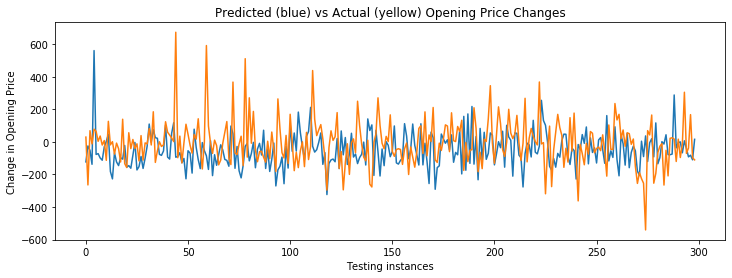

In [57]:
plt.figure(figsize=(12,4))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test)
plt.title("Predicted (blue) vs Actual (yellow) Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()

In [0]:
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [59]:
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))

Predicted values matched the actual direction 55.52% of the time.
